In [2]:
from keras.layers import Input, Dense
from keras.models import Model
from collections import Counter
from Bio import SeqIO

Using TensorFlow backend.


In [3]:
# Load sequences, because we're lazy don't bother with anything not 566 amino acids long.
sequences = []
years = []
for s in SeqIO.parse('h3n2.fasta', 'fasta'):
    try:
        assert len(s) == 566
        year = int(s.id.split('/')[-1])
        assert year in range(2000, 2018)
        
        sequences.append(s)
        years.append(year)
    except:
        pass

# Find distribution of lengths
lengths = [len(s) for s in sequences]
Counter(lengths)

Counter({566: 8349})

In [4]:
len(sequences), len(years)

(8349, 8349)

In [5]:
# Figure out how many unique letters are being used.
letters = set()
for s in sequences:
    letters = letters.union(s.seq)

In [6]:
letters

{'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'V',
 'W',
 'X',
 'Y',
 'Z'}

In [7]:
# Convert sequences into numpy array.
import numpy as np
arr = np.array([list(rec) for rec in sequences], np.character)

In [8]:
np.unique(arr)

array([b'A', b'B', b'C', b'D', b'E', b'F', b'G', b'H', b'I', b'J', b'K',
       b'L', b'M', b'N', b'P', b'Q', b'R', b'S', b'T', b'V', b'W', b'X',
       b'Y', b'Z'], 
      dtype='|S1')

In [9]:
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer

lb = LabelBinarizer()
alphabet = list(set(np.unique(arr)))
lb.fit(alphabet)

input_array = np.zeros(shape=(arr.shape[0], arr.shape[1] * len(alphabet)))

for i in range(arr.shape[1]):
    input_array[:, i:i+len(alphabet)] = lb.transform(arr[:, i])

In [10]:
from keras.layers import Input, Dense, Lambda, Dropout
from keras.models import Model
from keras import backend as K
from keras import objectives
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

intermediate_dim = 1000
encoding_dim = 2
latent_dim = encoding_dim
epsilon_std = 1.0
nb_epoch = 250

x = Input(shape=(input_array.shape[1],))
h = Dense(intermediate_dim, activation='relu')(x)
h = Dropout(p=0.5)(h)
# h = Dense(intermediate_dim, activation='relu')(h)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(latent_dim, ), mean=0.,
                              std=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon


def vae_loss(x, x_decoded_mean):
    xent_loss = input_array.shape[1] * objectives.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return xent_loss + kl_loss

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
h_decoded = Dense(intermediate_dim, activation='relu')(z)
h_decoded = Dropout(p=0.5)(h_decoded)
# h_decoded = Dense(intermediate_dim, activation='relu')(h_decoded)
x_decoded_mean = Dense(input_array.shape[1], activation='sigmoid')(h_decoded)

vae = Model(x, x_decoded_mean)
vae.compile(optimizer='adam', loss=vae_loss)

# build a model to project inputs on the latent space
encoder = Model(x, z_mean)
encoder_var = Model(x, z_log_var)

x_train, x_test = train_test_split(input_array)

early_stopping = EarlyStopping(monitor="val_loss", patience=10)

In [11]:
vae.fit(x_train, x_train,
        shuffle=True,
        nb_epoch=nb_epoch,
        validation_data=(x_test, x_test),
        callbacks=[early_stopping],
       )

Train on 6261 samples, validate on 2088 samples
Epoch 1/250
6261/6261 [==============================] - 6s - loss: 763.2483 - val_loss: 35.3966

In [12]:
embeddings = encoder.predict(input_array)

In [13]:
embeddings.shape

(8349, 2)

In [14]:
years

[2011,
 2015,
 2012,
 2015,
 2016,
 2011,
 2012,
 2016,
 2011,
 2015,
 2016,
 2010,
 2012,
 2014,
 2015,
 2016,
 2014,
 2015,
 2016,
 2016,
 2010,
 2012,
 2013,
 2014,
 2015,
 2010,
 2012,
 2014,
 2015,
 2014,
 2014,
 2015,
 2016,
 2010,
 2014,
 2015,
 2014,
 2014,
 2010,
 2016,
 2016,
 2016,
 2016,
 2016,
 2016,
 2012,
 2012,
 2016,
 2012,
 2016,
 2012,
 2012,
 2012,
 2012,
 2013,
 2012,
 2012,
 2014,
 2014,
 2014,
 2014,
 2014,
 2014,
 2014,
 2014,
 2014,
 2014,
 2014,
 2014,
 2014,
 2014,
 2015,
 2015,
 2015,
 2014,
 2015,
 2015,
 2010,
 2007,
 2007,
 2009,
 2011,
 2013,
 2014,
 2010,
 2012,
 2013,
 2013,
 2010,
 2012,
 2013,
 2015,
 2008,
 2010,
 2012,
 2012,
 2013,
 2016,
 2007,
 2010,
 2010,
 2013,
 2014,
 2016,
 2016,
 2007,
 2013,
 2014,
 2014,
 2016,
 2015,
 2011,
 2015,
 2015,
 2015,
 2015,
 2015,
 2015,
 2015,
 2015,
 2015,
 2015,
 2015,
 2015,
 2015,
 2015,
 2015,
 2015,
 2015,
 2015,
 2015,
 2015,
 2015,
 2015,
 2015,
 2015,
 2015,
 2015,
 2015,
 2015,
 2015,
 2015,
 2011,

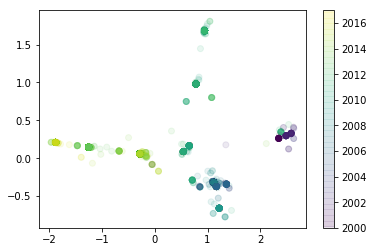

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(embeddings[:, 0], embeddings[:, 1], c=years, alpha=0.1)
plt.colorbar()
# plt.hist(embeddings[:, 0])
# plt.hist(embeddings[:, 1])
# plt.hist(embeddings[:, 2])